### Defining the aoi

In [1]:
import pandas as pd
import numpy as np
import xarray as xa
from pathlib import Path
import src.data.ecostress_io as eio
import src.data.ecostress_stack as es
import src.data.era_stack_resample as esr
import rioxarray
import sys
import geopandas as gpd
import json
import dask
from dask.distributed import Client
import matplotlib.pyplot as plt
xa.set_options(display_style='html')
n_partitions = 8 # set in the files
root_path = Path("/raid/scratch/rave/rhone-ecostress/rhone-ecostress-data")
reanalysis_path = Path(root_path, "era5-download.nc")
bounds_tuple = (4, 42, 7, 47)
xmin, ymin, xmax, ymax = bounds_tuple  # hardcoding since concattenating 1000s of ecostress files with different overlaps hangs

### Subsetting global rivers dataset
This dataset needs to be examined more closely. some second order streams appear to be missed and I'm not sure if channels are digitized as river.

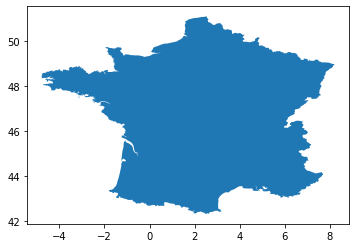

In [2]:
rhone_river_df = gpd.read_file(Path(root_path, "rhone_river_buffered_5000m.geojson"))

aoi = es.filter_countries_for_france_aoi(root_path)

aoi.crs = rhone_river_df.crs # setting crs for aoi

### making path lists to products

In [3]:
l3qa_path = Path(root_path, "ECO3ANCQA")
et_path = Path(root_path, "ECO3ETPTJPL")
esi_path = Path(root_path, "ECO4ESIPTJPL")
l2_path = Path(root_path, "ECO2")

# tempdir_daily = root_path/"tmp-daily-nearest"
# whole_tif_etdaily_paths, csv_et_paths, xml_et_paths = eio.separate_by_pattern(et_path, "*ETdaily*.tif")

tempdir_inst = root_path/"tmp-inst-nearest"
whole_tif_etinst_paths, csv_etinst_paths, xml_etinst_paths = eio.separate_by_pattern(et_path, "*ETinst_*.tif")

tempdir_inst_uncertainty = root_path/"tmp-inst_uncertainty-nearest"
whole_tif_etinst_uncertainty_paths, csv_etinst_uncertainty_paths, xml_etinst_uncertainty_paths = eio.separate_by_pattern(et_path, "*ETinstUncertainty*.tif")

# tempdir_l3qa = root_path/"tmp-l3qa"
# whole_tif_l3qa_paths, csv_qa_paths, xml_qa_paths = eio.separate_by_pattern(l3qa_path)

tempdir_l2qa = root_path/"tmp-l2qa"
whole_tif_l2qa_paths, csv_l2qa_paths, xml_l2qa_paths = eio.separate_by_pattern(l2_path, "*SDS_QC*.tif")

tempdir_l2cloud = root_path/"tmp-l2cloud"
whole_tif_l2cloud_paths, csv_l2cloud_paths, xml_l2cloud_paths = eio.separate_by_pattern(l2_path, "*SDS_CloudMask*.tif")

In [4]:
x = eio.read_ecostress_scene(whole_tif_etinst_uncertainty_paths[0])
resolution = x.rio.resolution()
x.close()
aoi_grid = eio.gdf_to_dataarray(rhone_river_df, rhone_river_df.crs, resolution)

In [5]:
envelope = rhone_river_df.unary_union.envelope

In [6]:
from geocube.api.core import make_geocube
rhone_arr = make_geocube(vector_data=rhone_river_df, resolution=resolution)

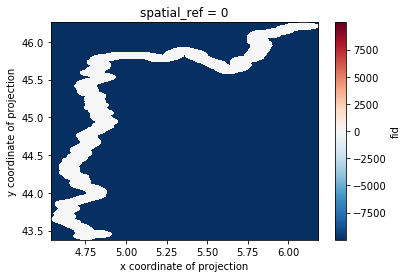

In [7]:
rhone_arr['fid'].plot.imshow()

Making the aoi grid for resampling

In [8]:
from rasterio.enums import Resampling
# etdaily_tseries_paths = es.clip_resample_ecostress(whole_tif_etdaily_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_daily, resampling_method=Resampling.nearest)
etinst_tseries_paths = es.clip_resample_ecostress(whole_tif_etinst_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_inst, resampling_method=Resampling.nearest)
etinst_uncertainty_tseries_paths = es.clip_resample_ecostress(whole_tif_etinst_uncertainty_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_inst_uncertainty , resampling_method=Resampling.nearest)
# l3qa_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_l3qa_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_l3qa, resampling_method=Resampling.nearest)
l2qa_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_l2qa_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_l2qa, resampling_method=Resampling.nearest)
l2cloud_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_l2cloud_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_l2cloud, resampling_method=Resampling.nearest)

In [9]:
etinst_da_list = eio.read_scenes(etinst_tseries_paths, chunks = {"band":1})
# l3qa_tseries, etinst_da_list = es.read_and_concat(l3qa_tseries_paths, etinst_da_list)
l2qa_tseries, etinst_da_list = es.read_and_concat(l2qa_tseries_paths, etinst_da_list)
l2cloud_tseries, etinst_da_list = es.read_and_concat(l2cloud_tseries_paths, etinst_da_list)
#etinst_uncertainty_tseries, etinst_da_list = es.read_and_concat(etinst_uncertainty_tseries_paths, etinst_da_list)
etinst_tseries = xa.concat(etinst_da_list, dim="date").sortby('date')

In [10]:
etinst_tseries = etinst_tseries.persist()
# suddenly this seems to hang, commenting since I don't use it yet to filter
#etinst_uncertainty_tseries = etinst_uncertainty_tseries.persist()
l2cloud_tseries = l2cloud_tseries.persist()
l2qa_tseries = l2qa_tseries.persist()
# l3qa_tseries = l3qa_tseries.persist()

In [11]:
from src.data.process_rivers import get_aoi_grid_from_rivers
import geopandas
from shapely.geometry import box, mapping

/home/rave/rhone-ecostress/src/data/ecostress_stack.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france_rivers_df['geometry'] = buffered_france_rivers_df


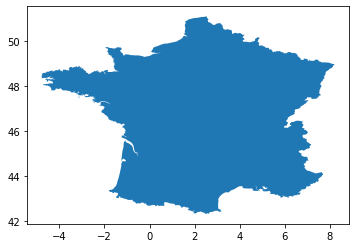

In [12]:
aoi_grid = get_aoi_grid_from_rivers()

In [13]:
rhone_arr_reprojected = rhone_arr.rio.reproject_match(aoi_grid)['fid']

In [14]:
geodf = gpd.GeoDataFrame(
    geometry=[
        box(*rhone_arr['fid'].rio.bounds())
    ],
    crs=rhone_arr['fid'].rio.crs.to_dict()
)

In [15]:
clipped_rhone_arr = rhone_arr_reprojected.rio.clip(geodf.geometry.apply(mapping), geodf.crs, drop=True, invert=False)

In [16]:
etinst_tseries = etinst_tseries.rio.clip(geodf.geometry.apply(mapping), geodf.crs, drop=True, invert=False)

#### bit order for qa masks follows landsat, right to left for bit ordering, left to right for each double bit that represent conditions.
https://www.usgs.gov/land-resources/nli/landsat/landsat-collection-1-level-1-quality-assessment-band?qt-science_support_page_related_con=0#qt-science_support_page_related_con

In [17]:
from src.data import qa_filter
ints_to_keep = qa_filter.get_good_qa_ints_to_keep_l2qa()

### Bad L2 flag filtering

In [18]:
nonnan_count_without_masking = (etinst_tseries != -1.0e13).sum()

nomask_count = nonnan_count_without_masking.compute()

l2qa_mask = l2qa_tseries.isin(ints_to_keep)

etinst_l2qamasked = xa.ufuncs.logical_and(l2qa_mask, (etinst_tseries != -1.0e13))

# nonnan_count_with_masking = etinst_l2qamasked.sum()

# l2qa_masked_count = nonnan_count_with_masking.compute()

# l2qa_masked_count/nomask_count

In [19]:
cloud_ints_to_keep = qa_filter.get_good_qa_ints_to_keep_l2cloud()

In [20]:
l2cloud_mask = l2cloud_tseries.isin(cloud_ints_to_keep)

In [21]:
etinst_l2allmask = xa.ufuncs.logical_and(l2cloud_mask, etinst_l2qamasked)

# nonnan_count_with_masking = etinst_l2allmask.sum()

# l2qacloud_masked_count = nonnan_count_with_masking.compute()

# l2qacloud_masked_count/nomask_count

In [22]:
# et_2018_june_sept=etinst_l2allmask.sel(date=slice("2018-06-01", "2018-09-30"))

# true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

# true_count_c = true_count.compute()

# f, ax = plt.subplots(1)
# true_count_c.plot.imshow(ax=ax)
# plt.title("Number of ECOSTRESS Observations after L2 QA filtering, June-Sept 2018")
# rivers_df.cx[xmin:xmax, ymin:ymax].plot(ax=ax, edgecolor="red")
# f.set_size_inches(18.5, 10.5)

In [23]:
# et_2019_june_sept=etinst_l2allmask.sel(date=slice("2019-06-01", "2019-09-30"))

# true_count = et_2019_june_sept.sel(band=1).sum(dim="date")

# true_count_c = true_count.compute()

# f, ax = plt.subplots(1)
# true_count_c.plot.imshow(ax=ax)
# plt.title("Number of ECOSTRESS Observations after L2 QA filtering, June-Sept 2019")
# rivers_df.cx[xmin:xmax, ymin:ymax].plot(ax=ax, edgecolor="red")
# f.set_size_inches(18.5, 10.5)

In [26]:
etinst_tseries.name = "ECO3ETPTJPL"
etinst_tseries = etinst_tseries.sel(date=slice("2018-01-01", "2018-12-31"))
# etinst_uncertainty_tseries = etinst_uncertainty_tseries.sel(date=slice("2018-01-01", "2018-12-31"))
l2cloud_tseries = l2cloud_tseries.sel(date=slice("2018-01-01", "2018-12-31"))
l2qa_tseries = l2qa_tseries.sel(date=slice("2018-01-01", "2018-12-31"))
# l3qa_tseries = l3qa_tseries.sel(date=slice("2018-01-01", "2018-12-31"))

In [27]:

et_tseries_ds = etinst_tseries.to_dataset().sel(band=1)

In [28]:
et_tseries_ds_nearest_hour_times = [pd.to_datetime(i.strftime("%Y-%m-%d %H")) for i in pd.to_datetime(et_tseries_ds.date.values)]

In [29]:
et_tseries_ds['date'] = et_tseries_ds_nearest_hour_times

In [30]:
et_tseries_ds.attrs['units'] = "W/m^2"

In [53]:
et_concat_ds = es.merge_duplicates(et_tseries_ds, etinst_tseries)

NameError: name 'etinst_tseries' is not defined

### Processing ERA Land Reanalysis data, or reading it if it has been previously processed and saved

9km nominal resolution is downsampled to Ecostress resolution on a 4326 geographic grid spanning the bounding box defined above. The hourly ERA had to be processed month by month and then concatenated together and resaved at the dest_path. See era_stack_resample and ecostress_stack for how these files were created.

In [125]:
july_clipped_et_t_path = root_path/"July-Hourly_VPD_clipped_et_times.nc"
august_clipped_et_t_path = root_path/"August-Hourly_VPD_clipped_et_times.nc"
sept_clipped_et_t_path = root_path/"September-Hourly_VPD_clipped_et_times.nc"

In [127]:
july = xa.open_dataset(july_clipped_et_t_path)
august = xa.open_dataset(august_clipped_et_t_path)
sept = xa.open_dataset(sept_clipped_et_t_path)

In [135]:
vpd_et_times = xa.concat([july, august, sept], dim="time").sortby("time")

In [150]:
non_daylight_time_list = list(set(et_concat_ds.date.values).symmetric_difference(set(vpd_et_times.time.values)))

In [157]:
non_daylight_mask = ~np.isin(et_concat_ds.date.values, non_daylight_time_list)
et_concat_ds = et_concat_ds.isel(date=non_daylight_mask)


In [162]:
et_vpd_rhone = et_concat_ds.rename({"date":"time"}).merge(vpd_et_times)

In [163]:
et_vpd_rhone

,Array,Chunk
Bytes,2.59 GB,47.93 MB
Shape,"(54, 4573, 2620)","(1, 4573, 2620)"
Count,2566 Tasks,54 Chunks
Type,float32,numpy.ndarray


In [185]:
et_vpd_rhone = et_vpd_rhone.chunk({'time': -1, "y":500, "x":500}) # time axis needs to be one chunk for correlation

In [222]:
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=0, keepdims=False))
            * (y - y.mean(axis=0, keepdims=False))).mean(axis=-1)

def pearson_correlation(x, y, dim):
    return xa.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

def covariance(x, y, dim):
    return xa.apply_ufunc(
        covariance_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

In [223]:
cov_result = covariance(et_vpd_rhone['ECO3ETPTJPL'], et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'], 'time')

In [224]:
cov_computed=cov_result.compute()

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [226]:
cov_computed.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [221]:
np.unique(et_vpd_rhone['ECO3ETPTJPL']-et_vpd_rhone['ECO3ETPTJPL'].mean(axis=0, keepdims=False))

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([-356.65793, -354.99   , -353.6608 , ...,        nan,        nan,
              nan], dtype=float32)

In [188]:
corr_result = pearson_correlation(et_vpd_rhone['ECO3ETPTJPL'], et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'], 'time')

In [189]:
computed_corr = corr_result.compute()

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


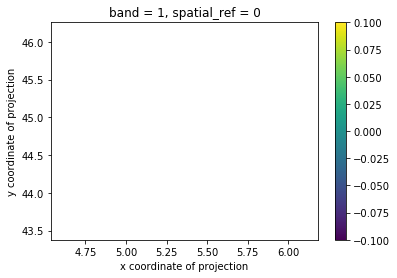

In [191]:
computed_corr.plot.imshow()

In [176]:
corr_result.to_netcdf(root_path/"vpd_et_inst_corr_result_july_sept.nc")

AttributeError: 'numpy.ndarray' object has no attribute 'to_netcdf'

In [24]:
#from xhistogram.xarray import histogram

In [44]:
#xa.plot.hist(etinst_uncertainty_tseries.where(etinst_uncertainty_tseries > 0), figsize=(12,6), bins=100)

In [45]:
#xa.plot.hist(etinst_tseries.where(etinst_tseries > 0), figsize=(12,6), bins=100)

In [31]:
#etinst_tseries_uncetaintylt50 = etinst_tseries.where(etinst_tseries != -1e+13).where(etinst_uncertainty_tseries < 150)

# merge is incorrect, need to debug

In [ ]:
import numpy.ma as ma

A = [1, 2, 3, 4, 5, np.NaN]
B = [2, 3, 4, 5.25, np.NaN, 100]

print(ma.corrcoef(ma.masked_invalid(A), ma.masked_invalid(B)))

Correlation ignoring nans with xarray options and helpful links
- https://stackoverflow.com/questions/31619578/numpy-corrcoef-compute-correlation-matrix-while-ignoring-missing-data
- http://martin-jung.github.io/post/2018-xarrayregression/
- https://github.com/pydata/xarray/pull/3550

#### Daily ET processing, focusing on isnt ET first since it looks to be more reliable based on intersecting scene comparison

Need to merge ET arrays taken on same date together to reduce time coord duplicates that occur because of partial scene overlaps and large aoi. nanmean should replace nans with a true value, 2 or more true values with the mean for that day (should only happena t the overlaps, infrequently), and all nan slices with nan.

Below I'm working on joining vpd and et by time and removing duplicates

Profiling why there are edge effects between ET Daily Scenes

In [ ]:
duplicate_dates = [pd.to_datetime(date).strftime("%Y-%m-%d") for date in duplicate_dates]


In [ ]:
resampled_data_arrays[0]['date'].dt.month.values

In [ ]:
for path in whole_tif_etdaily_paths:
    if "2018222" in str(path):
        print(path)

In [ ]:
resampled_data_arrays_profile = []
for da in resampled_data_arrays:
    if str(da.date.dt.month.values) == "8" and str(da.date.dt.year.values) == "2018" and str(da.date.dt.day.values) == "10":
        resampled_data_arrays_profile.append(da.where(da!=-1e+13))

In [ ]:
resampled_data_arrays_profile[0][0].plot.imshow()

In [ ]:
resampled_data_arrays_profile[1][0].plot.imshow()

In [ ]:
resampled_data_arrays_profile[-1][0].plot.imshow()

Instantaeous uncertainty

In [ ]:
inst_uncertainty_paths = ["/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222131552_aid0001.tif",
"/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222180613_aid0001.tif",
"/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222180704_aid0001.tif"]

In [ ]:
inst_uncertainty_paths = [Path(path) for path in inst_uncertainty_paths]

In [ ]:
clipped_uncertainty_paths = eio.clip_and_save(inst_uncertainty_paths, bounds_tuple, filter_nan = True, outDir=Path('/home/ryan/work/'))

In [ ]:
uncertainty_scenes = eio.read_scenes([Path(path) for path in clipped_uncertainty_paths])


In [ ]:
uncertainty_scenes[0][0].attrs['units'] = "W/m^2"
uncertainty_scenes[0][0].plot.imshow(figsize=(10,10))

In [ ]:
uncertainty_scenes[1][0].plot.imshow(figsize=(10,10))

In [ ]:
uncertainty_scenes[2][0].plot.imshow(figsize=(10,10))

Plotting histograms where scenes intersect

In [ ]:
date_to_plot = duplicate_dates[1]
n_scenes = len(et_tseries_ds_dups.sel(time=date_to_plot)['time'])
data_to_plot = et_tseries_ds_dups["ECO3ETPTJPL"].sel(time=date_to_plot).drop("band")

In [ ]:
valid_intersect_data = data_to_plot.where((data_to_plot[0] > 0) & (data_to_plot[1] > 0) & (data_to_plot[2] > 0))

In [ ]:
f, ax = plt.subplots(1)
xa.plot.hist(valid_intersect_data[0],ax=ax, alpha=.6, bins = 25)
xa.plot.hist(valid_intersect_data[1],ax=ax, alpha=.6, bins = 25)
xa.plot.hist(valid_intersect_data[2],ax=ax, alpha=.6, bins = 25)
plt.title("Instantaneous ET Disagreement between the intersection of 3 Ecostress scenes on August 10, 2018, France")

In [ ]:
data_to_plot['time'] = [0, 1, 2]
data_to_plot.attrs['units'] = "W/m^2"
data_to_plot.plot.imshow(x='x', y='y', col='time', col_wrap=n_scenes, robust=True, figsize=(20,8))
# plt.title(f"{n_scenes} individual scenes for date {date_to_plot}", fontsize=20)

In [ ]:
f,ax = plt.subplots(1)
date_to_plot = duplicate_dates[1]
et_vpd_ds["ECO3ETPTJPL"].sel(time=date_to_plot).plot.imshow(ax=ax)
f.set_size_inches(18.5, 10.5)
n_scenes = len(et_tseries_ds_dups.sel(time=date_to_plot)['time'])
plt.title(f"{n_scenes} scenes for date {date_to_plot}, mean taken at overlaps", fontsize=20)

Plotting ecostress availability

In [ ]:
et_tseries = et_tseries.sel(band=1)

In [ ]:
et_2018_may_sept=et_tseries.sel(date=slice("2018-06-01", "2018-09-30"))

et_2018_may_sept=et_2018_may_sept.chunk(chunks={"date": 101, "y": 1000, "x": 1000})

et_2018_may_sept = et_2018_may_sept.where(et_2018_may_sept > 0)

et_nonnan_count = ~np.isnan(et_2018_may_sept)

true_count = et_nonnan_count.astype(bool).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations, May-Sept 2018")
france_river_lines.plot(ax=ax, color="red")
f.set_size_inches(18.5, 10.5)

Aggregating hourly data to dekad

In [ ]:
pev_dekad = met_dataset['pev'].resample(time='1D').sum().resample(time='10D').mean()

pev_dekad_2018 = pev_dekad.sel(time=slice("2018-01-01", "2018-10-01"))

met_dataset['pev'].sel(time="2019-04-01")

pev_dekad_2019.plot(x='longitude', y='latitude', col='time', col_wrap=5)

## pretty ET plotting

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)
date_utc = pd.to_datetime(et['date'].values)
layer_type = et.attrs['filename'].split("_")[-3]
title = 'ECO3ETPTJPL Evapotranspiration'

fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
fig.suptitle(f'{title} ({layer_type}) \n at {date_utc}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(et.sel(band=1), cmap=ETcmap);                                                        # Plot array using colormap
# plt.scatter(Tcol, Trow, color="black", marker='x')                                        # Plot tower location
# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f"ET ({et.attrs['units']})", shrink=0.6).outline.set_visible(True)

## Code graveyard

trying to plot xarray image data and geopandas data with ipyleaflet but it can't do image overlays yet (unless it comes from a server via url potentially)

In [ ]:
import ipyleaflet as ipyl
x = france_river_lines.unary_union.envelope.centroid.xy[0][0]
y = france_river_lines.unary_union.envelope.centroid.xy[1][0]
e, n, w, s =true_count_c.rio.bounds()
m = ipyl.Map(center = (y,x), zoom=6)

rivers_data = ipyl.GeoData(geo_dataframe = france_river_lines,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Rivers')
m.add_layer(rivers_data)
plt.imsave("observation_count.jpeg",true_count_c)
obs_heatmap = ipyl.ImageOverlay(
    url="observation_count.jpeg",
    bounds=((s, w), (n, e))
)

m.add_layer(obs_heatmap)
m

trying to plot ecostress DataArray with geopandas shapes

In [ ]:
def cartopy_project_geo_df(df, crs):

    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    return df.to_crs(crs_proj4)

crs = ccrs.PlateCarree()
aoi_projected = cartopy_project_geo_df(aoi, crs)
france_rivers_df_projected = cartopy_project_geo_df(france_rivers_df, crs)
# base = aoi_projected.plot(color="grey", edgecolor="black")
# france_rivers_df_projected.plot(ax=base, color="blue")


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=crs)
all_et_daily[14].sel(band=1).plot.imshow(ax=ax, transform=crs)
# ax.add_geometries(aoi_projected['geometry'], crs=crs)
ax.add_geometries(france_rivers_df_projected['geometry'], crs=crs)

In [ ]:
def mask_NA_values():
    """
    Daily ET products have both nan values from where there are clouds 
    and -1e+13 for where the ecostress swath was clipped during the ordering process
    """
    masked_et = np.ma.masked_where(et.sel(band=1) == np.nan, et.sel(band=1))
    masked_et = np.ma.masked_where(masked_et == -1e+13, masked_et)

In [ ]:
base = aoi.plot(color="grey", edgecolor="black")

france_rivers_df.plot(ax=base, color="blue")